![Banner](img/AI_Special_Program_Banner.jpg)

## Text Mining - Exercise (Embeddings)
---
* Instructions are given in <span style="color:blue">blue</span> color.
* Feel free to insert more cells wherever you see fit.

In this exercise, it will be your turn to improve the Sentiment Analysis performed earlier even further. Instead of training an embedding layer in PyTorch, we want to train a **word2vec** embedding and use it as a non-trainable layer in our LSTM. This requires only a few changes in the model (the code is already there), but you need to create the word2vec model using the movie review data!

The exercise builds on material from *Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

In [1]:
# Libraries and packages
import os
import gzip
import shutil
import random

import numpy as np
import pandas as pd
import collections

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data import get_tokenizer
from torch import nn

import datetime as dt

In [2]:
# importing module for training loop
from train_loop import train, train_for_epochs, validate, plot_history

In [3]:
CUDA_AVAILABLE = torch.cuda.is_available()
print(f'CUDA_AVAILABLE = {CUDA_AVAILABLE}')

CUDA_AVAILABLE = True


In [4]:
USE_ONLY_CPU = False

In [5]:
random.seed(42)     # python random generator
np.random.seed(42)  # numpy random generator

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

### Example: Sentiment analysis of movie reviews
---
* reading data as *external data* and transforming dataset for PyTorch
* also available as [PyTorch Dataset](https://pytorch.org/text/stable/datasets.html#imdb)

In [6]:
df = pd.read_csv('data/movie_data.csv', encoding='utf-8')
df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


#### Preprocessing (old)

In [7]:
target = df['sentiment']

values = df['review']

target[0], values[0]

(1,
 'In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich 

#### Preprocessing (new)

Removing punctuation and stop words.

In [8]:
import re
import nltk
nltk.download('stopwords')

stopwords_eng = set(nltk.corpus.stopwords.words("english"))
#print(stopwords_eng)

def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub("[^a-z]", " ", text) #remove all punctation
    words = [word for word in text.split() if word not in stopwords_eng]
    text = " ".join(words)
    return text

reviews = df.review
reviews = reviews.map(clean_text)
df.review = reviews

target = df['sentiment']
values = df['review']

target[0], values[0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(1,
 'teenager martha moxley maggie grace moves high class area belle greenwich connecticut mischief night eve halloween murdered backyard house murder remained unsolved twenty two years later writer mark fuhrman christopher meloni former la detective fallen disgrace perjury j simpson trial moved idaho decides investigate case partner stephen weeks andrew mitchell purpose writing book locals squirm welcome support retired detective steve carroll robert forster charge investigation discover criminal net power money cover murder br br murder greenwich good tv movie true story murder fifteen years old girl committed wealthy teenager whose mother kennedy powerful rich family used influence cover murder twenty years however snoopy detective convicted perjurer disgrace able disclose hideous crime committed screenplay shows investigation mark last days martha parallel lack emotion dramatization vote seven br br title brazil available')

Performing `WordNet` lemmatization.

In [9]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
lemmas = list()

def clean_text2(text):
    words = [lemmatizer.lemmatize(word, pos='v') for word in text.split()]
    text = " ".join(words)
    return text

reviews = df.review
reviews = reviews.map(clean_text2)
df.review = reviews

target = df['sentiment']
values = df['review']

target[0], values[0]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(1,
 'teenager martha moxley maggie grace move high class area belle greenwich connecticut mischief night eve halloween murder backyard house murder remain unsolved twenty two years later writer mark fuhrman christopher meloni former la detective fall disgrace perjury j simpson trial move idaho decide investigate case partner stephen weeks andrew mitchell purpose write book locals squirm welcome support retire detective steve carroll robert forster charge investigation discover criminal net power money cover murder br br murder greenwich good tv movie true story murder fifteen years old girl commit wealthy teenager whose mother kennedy powerful rich family use influence cover murder twenty years however snoopy detective convict perjurer disgrace able disclose hideous crime commit screenplay show investigation mark last days martha parallel lack emotion dramatization vote seven br br title brazil available')

 **Setup Dataset** <br>
Here we setup a pytorch dataset which also performs tokenization. As also done in Chapter 5.
   * `torchtext.data.utils.get_tokenize`: https://pytorch.org/text/stable/data_utils.html

In [10]:
target.shape, values.shape

((50000,), (50000,))

In [11]:
class ReviewDataset(Dataset):
    def __init__(self, target, values):
        self.target = target
        self.values = values
        # setup tokenizer
        tokenizer_name = 'basic_english' 
        self.tokenizer = get_tokenizer(tokenizer_name)
        # setup vocab
        counter_obj = collections.Counter()
        for v in values:
            tokens = self.tokenizer(v)
            counter_obj.update(tokens)
        self.vocab = torchtext.vocab.vocab(counter_obj, min_freq=1, specials=['<unk>'])
        # set a default index for out of vocabulary tokens
        self.vocab.set_default_index(-1)
        
    def __encode(self, value):
        tokens = self.tokenizer(value)
        return torch.tensor(self.vocab.lookup_indices(tokens))
    
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        return self.__encode(self.values[idx]), torch.tensor(target[idx]).float()
    
dataset = ReviewDataset(target=target.values, values=values.values)
len(dataset), dataset[0]

(50000,
 (tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
           15,  16,  17,  18,  19,  17,  20,  21,  22,  23,  24,  25,  26,  27,
           28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,   6,  40,
           41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
           55,  56,  33,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
           68,  17,  69,  69,  17,  11,  70,  71,  72,  73,  74,  17,  75,  24,
           76,  77,  78,  79,   1,  80,  81,  82,  83,  84,  85,  86,  87,  68,
           17,  22,  24,  88,  89,  33,  90,  91,  35,  92,  93,  94,  95,  78,
           96,  97,  62,  27,  98,  99,   2, 100, 101, 102, 103, 104, 105,  69,
           69, 106, 107, 108]),
  tensor(1.)))

**train/validation/test split** <br>
Here we set up a train test split and also perform batching and padding. As also done in Chapter 5.

In [12]:
# setup train test split
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [30000, 5000, 15000])
print(f'Len train set: {len(train_set)}')
print(f'Len val set: {len(val_set)}')
print(f'Len test set: {len(test_set)}')

# setup data loader
def batch_and_pad(data):
    values = [d[0] for d in data]
    labels = [d[1].unsqueeze(0) for d in data]
    return torch.nn.utils.rnn.pad_sequence(values, batch_first=True), torch.stack(labels)
    
train_loader = DataLoader(train_set, batch_size=32, collate_fn=batch_and_pad)
val_loader = DataLoader(val_set, batch_size=32, collate_fn=batch_and_pad)
test_loader = DataLoader(test_set, batch_size=32, collate_fn=batch_and_pad)

Len train set: 30000
Len val set: 5000
Len test set: 15000


In [13]:
print('Vocab-size:', len(dataset.vocab))

Vocab-size: 86261


As can be observed, the vocabulary size is now much smaller than it was without using `nltk` for preprocessing.

#### Creating a word2vec model

This is the part where you are finally asked to chime in.
To remind you: The general plan for this exercise is to replace the built-in PyTorch embedding layer with a self-trained word2vec layer (transfer learning).

* <div style="color:blue">First, from the initial <code>DataFrame</code> create a list that contains all the movie reviews.</div>

In [25]:
new_list = df["review"].tolist()

* <div style="color:blue">Next, each document in your list needs to be transformed (tokenized) into a list of tokens (as this is what word2vec expects). Use <code>word_tokenize()</code> by nltk to do so.</div>

In [31]:
from nltk import word_tokenize
nltk.download('punkt')

# Your solution goes here:
list_tmp = [word_tokenize(item) for item in new_list]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


* <div style="color:blue">Now create your <code>gensim</code> word2vec model (don't forget the imports). Your model should consider the following settings:</div>
    
    - (context) window: 5
    - (embedding) size: 20
    - minimum term count: 1

In [38]:
# Your solution goes here:
import gensim

model = gensim.models.Word2Vec(list_tmp, min_count=1, window=5, vector_size=20)

* <div style="color:blue">Test your model for finding similar words to the sentiments <b>good</b> and <b>horrible</b>.</div>

In [41]:
# Your solution goes here:
model.wv.similar_by_word("horrible", topn=10)

[('terrible', 0.9776986837387085),
 ('awful', 0.9655641317367554),
 ('bad', 0.9138228297233582),
 ('pathetic', 0.8971858024597168),
 ('horrendous', 0.8853651285171509),
 ('suck', 0.8835744857788086),
 ('atrocious', 0.8643937110900879),
 ('dreadful', 0.8542830348014832),
 ('ridiculous', 0.8453726768493652),
 ('lousy', 0.8397698998451233)]

If you want, you can also save the model to disk for later use.

In [ ]:
# model_w2v.wv.save_word2vec_format("models/w2v_movies.txt")

#### Creating Embedding Matrix

We now have two separate parts required to perform our LSTM training with self-trained word embeddings:
- the prepared training and test data
- the trained word2vec embedding
    
To bring these parts together, we now need to create an embedding matrix that returns the vectorized embedding for a term in the training/test set.

* <div style="color:blue">Alter the following line of code so that it fits your implementation (replace the variable <code>model_w2v</code> with whatever your word2vec model is called).</div>

In [42]:
# Extracting the embedding vectors for the trained word2vec model
model_w2v = model
word_vectors = model_w2v.wv

In [43]:
# Checking if a word is present in the word2vec embedding
print('time' in word_vectors.index_to_key)

True


In [44]:
# Having a look at the vector representation of a single word
word_vectors.get_vector('time')

array([-3.2542949 ,  0.7497084 ,  2.398377  ,  0.03779702, -1.5857325 ,
       -1.559093  ,  0.3118762 ,  0.6034888 ,  3.9802744 ,  1.1889193 ,
        2.061123  ,  1.4334356 ,  1.4577407 , -1.926129  , -2.5262902 ,
       -0.8284587 ,  1.2472465 ,  1.458655  , -2.744066  , -0.67216986],
      dtype=float32)

In [45]:
# Getting all words from the training set
word_index = dataset.vocab.get_stoi()

# Initializing an empty embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 20))

# For each word in the training set, check if it is present in the embedding
for word, i in word_index.items():
    # if it is present, get the embedding vector and update the embedding matrix
    if word in word_vectors.index_to_key:
        embedding_matrix[i] = word_vectors.get_vector(word)

In [46]:
# Number of words in the training set
print(len(word_index))
# Embedding shape
print(embedding_matrix.shape)

86261
(86262, 20)


In [47]:
# Words that are not present in the embedding are represented as zeroes only
print(embedding_matrix[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Training the bidirectional LSTM

* <div style="color:blue">Finally, it is now time to replace the PyTorch embedding layer with an embedding layer that takes your custom embedding matrix into account. Alter the following function so that it does just that. Make sure your layer won't get weight updates during training!</div>

**Hint**: This is not a difficult task. [The PyTorch Embedding Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding.from_pretrained) might support you pretty well.

In [53]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, embedding_matrix, recurrent_type='RNN', bidirectional=False, n_recurrent_layers=1):
        super(RNNModel, self).__init__()
        # ************
        # PyTorch embedding layler. Replace this by using the embedding_matrix
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        # ************
        if recurrent_type == 'RNN':
            self.rnn = nn.RNN(embedding_dim, hidden_units, batch_first=True, bidirectional=bidirectional, num_layers=n_recurrent_layers)
        elif recurrent_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_units, batch_first=True, bidirectional=bidirectional, num_layers=n_recurrent_layers)
        elif recurrent_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_units, batch_first=True, bidirectional=bidirectional, num_layers=n_recurrent_layers)
        self.fc1 = nn.Linear(hidden_units * 2 if bidirectional else hidden_units, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.num_directions = 2 if bidirectional else 1
        self.hidden_units = hidden_units
        self.recurrent_type = recurrent_type

    def forward(self, x):
        batch_size, seq_len = x.shape
        embedded = self.embedding(x)
        #lstm also returns the cell hidden state
        if self.recurrent_type == "LSTM":
            output, (hidden, cell_hidden) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)
        # Concatenate the final hidden states from both directions if bidirectional
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        x = self.fc1(hidden)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

embedding_dim = 20
vocab_size = len(dataset.vocab)

rnn_type = 'LSTM'

model = RNNModel(vocab_size, embedding_dim, 64, embedding_matrix, recurrent_type=rnn_type, n_recurrent_layers=1, bidirectional=True)
model

RNNModel(
  (embedding): Embedding(86262, 20)
  (rnn): LSTM(20, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() and not USE_ONLY_CPU else "cpu")
print(f'Using {device} for training')

Using cuda for training


Now it is time to train your network and evaluate on the test data...

In [55]:
# Move the model weight to the desired device
model.to(device)

NUM_EPOCHS = 5

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

start_train = dt.datetime.now()
print(f'{rnn_type} training started: {start_train}')
# run training
history = train_for_epochs(device, NUM_EPOCHS, model, train_loader, val_loader, optimizer, criterion, binary=True)
finish_train = dt.datetime.now()
print(f'{rnn_type} training finished {finish_train} (duration: {finish_train - start_train})')

LSTM training started: 2024-02-01 13:36:07.549780


  0%|          | 0/5 [00:00<?, ?it/s]

LSTM training finished 2024-02-01 13:36:46.660990 (duration: 0:00:39.111210)


In [56]:
## evaluate on the test data
test_loss, test_accuracy = validate(device, model, test_loader, criterion)
print('\nTest Acc. {:.2f}%'.format(test_accuracy))


Test Acc. 86.87%


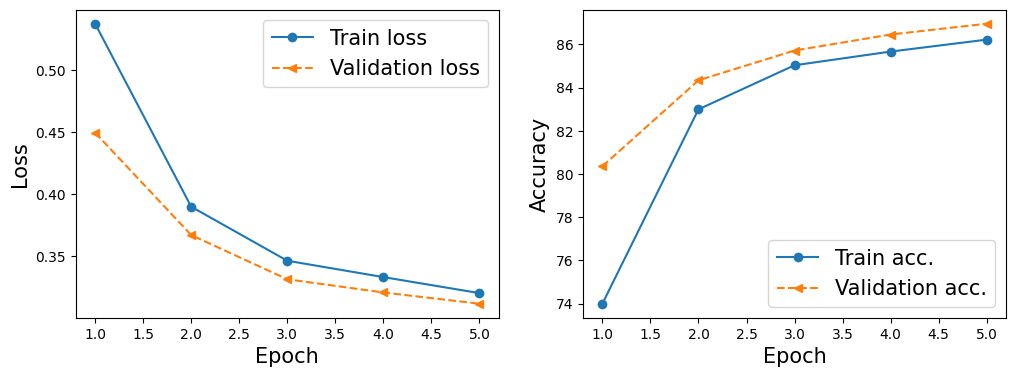

In [57]:
loss_train_hist = history['train']['loss']
acc_train_hist = history['train']['accuracy']
loss_val_hist = history['val']['loss']
acc_val_hist = history['val']['accuracy']

plot_history(loss_train_hist, acc_train_hist, loss_val_hist, acc_val_hist)

#plt.savefig('figures/15_12.png', dpi=300)
plt.show()